# Yelp Reviews on Portland's Cafés | Data Extraction

In [3]:
# import modules to run MongoDB
import pymongo
from pymongo import MongoClient
import getpass
import os

# import data munging modules
from pprint import pprint
import pandas as pd
import numpy as np

# import visualization modules
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [5]:
# stop running instance of MongoDB
password = getpass.getpass()
command = "!sudo -S service mongod stop" 
os.system('echo %s | %s' % (password, command))

 ···········


32512

In [6]:
# start new instance of MongoDB
password = getpass.getpass()
command = "!sudo -S service mongod start" 
os.system('echo %s | %s' % (password, command))

 ···········


32512

In [10]:
# connect the MongoDB
client = MongoClient()
db = client.yelp

# print number of documents in each collection
for c in db.list_collection_names():
    print('{:10}'.format(c), '{:>10,}'.format(db[c].estimated_document_count()))

user        2,189,457
tip         1,162,119
review      8,635,403
checkin       138,876
business      160,585


In [11]:
# connect relevant collections
reviews = db.review
businesses = db.business

In [12]:
# Mongo testing on one business
one_review = reviews.find_one()
one_business = businesses.find_one({'business_id':one_review['business_id']})
print('{:6}'.format('Name:'), one_business['name'])
print('{:6}'.format('City:'), one_business['city'])
pprint(one_business)

Name:  Renaissance Orlando at SeaWorld
City:  Orlando
{'_id': ObjectId('60c93f7e74f486d0ae9a3041'),
 'address': '6677 Sea Harbor Dr',
 'attributes': {'Alcohol': "u'full_bar'",
                'Ambience': "{'romantic': False, 'intimate': False, "
                            "'touristy': False, 'hipster': False, 'divey': "
                            "False, 'classy': False, 'trendy': False, "
                            "'upscale': False, 'casual': False}",
                'BusinessAcceptsBitcoin': 'False',
                'BusinessAcceptsCreditCards': 'True',
                'BusinessParking': "{'garage': False, 'street': False, "
                                   "'validated': False, 'lot': False, 'valet': "
                                   'False}',
                'ByAppointmentOnly': 'True',
                'DogsAllowed': 'False',
                'GoodForKids': 'True',
                'HasTV': 'True',
                'NoiseLevel': "u'quiet'",
                'OutdoorSeating': 'T

## 1. Create Cafes dataframe

In [56]:
# create full dataframe
business_coll = db.business
business_df = pd.DataFrame(list(business_coll.find()))

In [57]:
business_df.head()

,_id,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,60c93f7e74f486d0ae9a1ce3,tXvdYGvlEceDljN8gt2_3Q,Capital City Barber Shop,"615 W Slaughter Ln, Ste 113",Austin,TX,78748,30.172706,-97.799920,4.0,5,0,"{'BusinessAcceptsCreditCards': 'False', 'Resta...","Barbers, Beauty & Spas","{'Monday': '9:0-17:0', 'Tuesday': '9:0-19:0', ..."
1,60c93f7e74f486d0ae9a1ce4,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Beauty & Spas, Hair Salons",None
2,60c93f7e74f486d0ae9a1ce5,jFYIsSb7r1QeESVUnXPHBw,Boxwood Biscuit,740 S High St,Columbus,OH,43206,39.947007,-82.997471,4.5,11,1,None,"Breakfast & Brunch, Restaurants","{'Saturday': '8:0-14:0', 'Sunday': '8:0-14:0'}"
3,60c93f7e74f486d0ae9a1ce6,N3_Gs3DnX4k9SgpwJxdEfw,Lane Wells Jewelry Repair,"7801 N Lamar Blvd, Ste A140",Austin,TX,78752,30.346169,-97.711458,5.0,30,1,"{'RestaurantsPriceRange2': '1', 'ByAppointment...","Shopping, Jewelry Repair, Appraisal Services, ...","{'Monday': '12:15-17:0', 'Tuesday': '12:15-17:..."
4,60c93f7e74f486d0ae9a1ce7,D4JtQNTI4X3KcbzacDJsMw,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,"{'GoodForKids': 'True', 'Alcohol': 'u'none'', ...","Restaurants, Thai","{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'..."


In [58]:
business_df.shape

(160585, 15)

In [60]:
business_df.dtypes

_id              object
business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object

In [61]:
business_df['categories'].isnull().sum()

115

The **coffee-related categories** in Yelp are:<br/>
- Cafes
- Coffee & tea
- Coffee Roasteries

These will be the categories I will extract from the main business dataframe.

In [82]:
# filtered df containing only cafes
cafes_df = business_df[business_df['categories'].str.contains('Cafes', na = False)]

In [83]:
cafes_df

,_id,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
6,60c93f7e74f486d0ae9a1ce9,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
109,60c93f7e74f486d0ae9a1d50,aTAe3uMYBEwU0FbTMFEI5g,Urban Pantry,1128 NW Lovejoy St,Portland,OR,97209,45.529939,-122.682932,3.5,26,1,"{'HasTV': 'False', 'NoiseLevel': 'u'quiet'', '...","Do-It-Yourself Food, Restaurants, American (Tr...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-19:0', ..."
239,60c93f7e74f486d0ae9a1dd2,qxnHt71f5BHVmzWKDTRCyA,Artisan Park Club,1343 Celebration Ave,Kissimmee,FL,34747,28.299298,-81.554198,3.5,9,1,"{'RestaurantsTakeOut': 'True', 'Caters': 'True...","Event Planning & Services, Cafes, Restaurants,...","{'Tuesday': '12:0-15:0', 'Wednesday': '17:0-19..."
253,60c93f7e74f486d0ae9a1de0,r-hWf-bd9im5rj_l2MeofQ,Take Five Café,102-609 Granville Street,Vancouver,BC,V7Y 1H4,49.283532,-123.117107,4.0,17,1,"{'BikeParking': 'True', 'WiFi': ''free'', 'Res...","Food, Coffee & Tea, Restaurants, Cafes",None
282,60c93f7e74f486d0ae9a1dfd,GyglPdfJM89if_5XSBIN7Q,Never Coffee,537 SW 12th Ave,Portland,OR,97205,45.521433,-122.683917,4.0,49,1,"{'Ambience': '{'touristy': False, 'hipster': F...","Restaurants, Cafes, Food, Coffee & Tea","{'Monday': '8:0-14:0', 'Friday': '8:0-14:0', '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160394,60c93f8274f486d0ae9c8f6d,um4x6dIkv8w2a4e0VkRNmA,Rocco's Cucina & Bar,450 Commercial St,Boston,MA,02109,42.367380,-71.053411,3.5,164,1,"{'RestaurantsTakeOut': 'True', 'WiFi': 'u'free...","Beer, Wine & Spirits, Italian, American (Tradi...","{'Monday': '14:30-1:30', 'Tuesday': '16:0-22:0..."
160399,60c93f8274f486d0ae9c8f72,wErvHalgCs_HzuQXSYaZQA,Big Bear Cafe & Espresso Bar,3 Eastern Ave,Dedham,MA,02026,42.247876,-71.172749,4.5,125,1,"{'WiFi': 'u'free'', 'RestaurantsTableService':...","Restaurants, Breakfast & Brunch, Food, Cafes, ...","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ..."
160504,60c93f8274f486d0ae9c8fdb,QMJ0uaY73v6OX2Wr5emEwg,Dudley Cafe,15 Warren St,Roxbury,MA,02119,42.330008,-71.083464,4.0,68,1,"{'BikeParking': 'False', 'RestaurantsAttire': ...","Breakfast & Brunch, Coffee & Tea, Bakeries, Re...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-15:0', '..."
160527,60c93f8274f486d0ae9c8ff2,dplKdpONowTjlPZvq0wSRw,Elysian Coffee,"1100 Burrard Street, Suite 102",Vancouver,BC,V6Z 1Y9,49.279845,-123.127654,4.0,53,1,"{'RestaurantsPriceRange2': '1', 'GoodForMeal':...","Coffee Roasteries, Breakfast & Brunch, Food, C...","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ..."


In [84]:
# filtered df containing only coffee & tea locations
coffee_tea_df = business_df[business_df['categories'].str.contains('Coffee & Tea', na = False)]

In [85]:
coffee_tea_df

,_id,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
39,60c93f7e74f486d0ae9a1d0a,iPD8BBvea6YldQZPHzVrSQ,Espresso Minute,334 Mass Ave,Boston,MA,02115,42.342673,-71.084239,4.5,7,0,"{'NoiseLevel': ''quiet'', 'GoodForKids': 'True...","Creperies, Restaurants, Food, Coffee & Tea, Br...","{'Tuesday': '8:0-20:0', 'Wednesday': '8:0-20:0..."
58,60c93f7e74f486d0ae9a1d1d,2-p3yffS70GvqJurMP_pgQ,Starbucks,"7910 Winter Garden-Vineland Rd, Ste 100",Windermere,FL,34786,28.446272,-81.559500,3.5,17,1,"{'BusinessAcceptsCreditCards': 'True', 'Busine...","Food, Coffee & Tea","{'Monday': '5:0-21:0', 'Tuesday': '5:0-21:0', ..."
66,60c93f7e74f486d0ae9a1d25,buTr0hMiyDbjQvFJgm-Eew,JP Licks,611 Assembly Row,Somerville,MA,02145,42.395406,-71.079491,3.5,131,1,"{'HasTV': 'False', 'RestaurantsTakeOut': 'True...","Custom Cakes, Desserts, Coffee & Tea, Ice Crea...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."
68,60c93f7e74f486d0ae9a1d27,z-0oY7VxQMQw3JHvdPejrA,Olmecas Mexican Restaurant,2121 E Oltorf St,Austin,TX,78741,30.230016,-97.732639,3.0,21,0,"{'Ambience': '{'romantic': False, 'intimate': ...","Coffee & Tea, Tex-Mex, Restaurants, Mexican, Food","{'Monday': '7:0-23:30', 'Tuesday': '7:0-23:30'..."
99,60c93f7e74f486d0ae9a1d46,ZA3u0Nu5V6TqkcYh8U0zdg,B Street Coffee House,2190 W Burnside St,Portland,OR,97210,45.523074,-122.696206,4.5,131,0,"{'Caters': 'False', 'RestaurantsAttire': 'u'ca...","Restaurants, Food, Sandwiches, Breakfast & Bru...","{'Monday': '6:30-15:0', 'Tuesday': '6:30-15:0'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160488,60c93f8274f486d0ae9c8fcb,o-oY7NSUN2zYW7qRHLjuSQ,Dunkin',5422 N Orange Blossom Trl,Orlando,FL,32810,28.607581,-81.425529,2.5,20,1,"{'OutdoorSeating': 'True', 'BikeParking': 'Tru...","Donuts, Coffee & Tea, Food","{'Monday': '5:0-20:0', 'Tuesday': '5:0-20:0', ..."
160504,60c93f8274f486d0ae9c8fdb,QMJ0uaY73v6OX2Wr5emEwg,Dudley Cafe,15 Warren St,Roxbury,MA,02119,42.330008,-71.083464,4.0,68,1,"{'BikeParking': 'False', 'RestaurantsAttire': ...","Breakfast & Brunch, Coffee & Tea, Bakeries, Re...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-15:0', '..."
160527,60c93f8274f486d0ae9c8ff2,dplKdpONowTjlPZvq0wSRw,Elysian Coffee,"1100 Burrard Street, Suite 102",Vancouver,BC,V6Z 1Y9,49.279845,-123.127654,4.0,53,1,"{'RestaurantsPriceRange2': '1', 'GoodForMeal':...","Coffee Roasteries, Breakfast & Brunch, Food, C...","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ..."
160531,60c93f8274f486d0ae9c8ff6,EaBDXdIQ_TeeUhn1Twnjvg,Shanghai Noodle House,"10300 Anderson Mill Rd, Ste A",Austin,TX,78750,30.447543,-97.804432,3.5,83,1,"{'RestaurantsAttire': 'u'casual'', 'Restaurant...","Restaurants, Bubble Tea, Coffee & Tea, Food, N...","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."


In [88]:
# filtered df containing only coffee roasteries
coffee_roast_df = business_df[business_df['categories'].str.contains('Coffee Roasteries', na = False)]

In [89]:
coffee_roast_df

,_id,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
397,60c93f7e74f486d0ae9a1e70,F0n25o5lpaFJpEW8DFS8Ww,Greater Goods Coffee Roasters,"12005 Bee Caves Rd, Ste 4B",Austin,TX,78738,30.307557,-97.926219,4.5,54,1,"{'RestaurantsDelivery': 'False', 'BikeParking'...","Coffee Roasteries, Cafes, Food, Coffee & Tea, ...","{'Monday': '0:0-0:0', 'Tuesday': '6:30-14:0', ..."
611,60c93f7e74f486d0ae9a1f46,VHTdTeuNQiQ6IsfCAdpKyQ,La Meca Coffee Growers & Roasters,173 N Country Club Rd,Lake Mary,FL,32746,28.758610,-81.321963,5.0,10,0,"{'WheelchairAccessible': 'False', 'Restaurants...","Coffee & Tea, Sandwiches, Restaurants, Food, C...",None
677,60c93f7e74f486d0ae9a1f88,ijXamJnJ1oVGKon_K-DYpA,Nespresso Boutique at Bloomingdales,225 Boylston St,Newton,MA,02467,42.321416,-71.175210,4.0,18,1,"{'RestaurantsReservations': 'False', 'Restaura...","Coffee & Tea Supplies, Food, Cafes, Coffee Roa...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-19:0', ..."
986,60c93f7e74f486d0ae9a20bd,2IC3gI6RsqXF3PtUVUjoTg,Starbucks,6289 Pullman Dr,Lewis Center,OH,43035,40.204670,-83.029320,3.0,10,1,"{'BusinessParking': '{'garage': False, 'street...","Coffee & Tea, Food, Coffee Roasteries","{'Monday': '5:30-20:0', 'Tuesday': '5:30-20:0'..."
1368,60c93f7e74f486d0ae9a223b,-M3ym49CjhILGvWWYW-rcg,Bitter Rose Coffee Bar,2035 NE 41st Ave,Portland,OR,97212,45.537658,-122.621337,4.5,22,1,"{'RestaurantsTakeOut': 'False', 'RestaurantsDe...","Coffee Roasteries, Coffee & Tea, Food","{'Monday': '7:0-15:0', 'Tuesday': '7:0-15:0', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158758,60c93f8274f486d0ae9c8909,UG6_dVkv1I5AV7NS3CG6Kg,Cultivate Food and Coffee,"1952 Howell Mill Rd NW, Ste 200",Atlanta,GA,30318,33.807925,-84.412883,4.0,288,1,"{'WiFi': 'u'free'', 'GoodForMeal': '{'dessert'...","Coffee & Tea, Food, Coffee Roasteries, Sandwic...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', '..."
159416,60c93f8274f486d0ae9c8b9b,jjMZb8SUVzoCqYQkWgOWKQ,Coffee Shop of Horrors,"17415 7th St, Ste A",Montverde,FL,34756,28.599875,-81.674922,5.0,30,1,"{'BikeParking': 'True', 'OutdoorSeating': 'Tru...","Coffee & Tea, Food, Coffee Roasteries, Desserts","{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ..."
159993,60c93f8274f486d0ae9c8ddc,jgV2cjCHA-7qTyipWuagsQ,Heart,537 SW 12th Ave,Portland,OR,97205,45.521966,-122.682915,4.0,330,0,"{'WiFi': 'u'free'', 'OutdoorSeating': 'True', ...","Coffee Roasteries, Food, Coffee & Tea","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ..."
160244,60c93f8274f486d0ae9c8ed7,J5lyUfjbwuaM5SjvJ8oxFQ,Nic & Luc Scratch Kitchen and Commissary,"851 E State Rd 434, Ste 128-130",Longwood,FL,32750,28.698805,-81.332071,5.0,69,1,"{'Alcohol': 'u'none'', 'RestaurantsDelivery': ...","Breakfast & Brunch, American (New), Food, Coff...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-14:0', ..."


In [90]:
# concatenate the three df about coffee-related businesses
cafes = pd.concat([cafes_df, coffee_tea_df, coffee_roast_df], ignore_index=True)

In [91]:
cafes.head()

,_id,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,60c93f7e74f486d0ae9a1ce9,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
1,60c93f7e74f486d0ae9a1d50,aTAe3uMYBEwU0FbTMFEI5g,Urban Pantry,1128 NW Lovejoy St,Portland,OR,97209,45.529939,-122.682932,3.5,26,1,"{'HasTV': 'False', 'NoiseLevel': 'u'quiet'', '...","Do-It-Yourself Food, Restaurants, American (Tr...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-19:0', ..."
2,60c93f7e74f486d0ae9a1dd2,qxnHt71f5BHVmzWKDTRCyA,Artisan Park Club,1343 Celebration Ave,Kissimmee,FL,34747,28.299298,-81.554198,3.5,9,1,"{'RestaurantsTakeOut': 'True', 'Caters': 'True...","Event Planning & Services, Cafes, Restaurants,...","{'Tuesday': '12:0-15:0', 'Wednesday': '17:0-19..."
3,60c93f7e74f486d0ae9a1de0,r-hWf-bd9im5rj_l2MeofQ,Take Five Café,102-609 Granville Street,Vancouver,BC,V7Y 1H4,49.283532,-123.117107,4.0,17,1,"{'BikeParking': 'True', 'WiFi': ''free'', 'Res...","Food, Coffee & Tea, Restaurants, Cafes",None
4,60c93f7e74f486d0ae9a1dfd,GyglPdfJM89if_5XSBIN7Q,Never Coffee,537 SW 12th Ave,Portland,OR,97205,45.521433,-122.683917,4.0,49,1,"{'Ambience': '{'touristy': False, 'hipster': F...","Restaurants, Cafes, Food, Coffee & Tea","{'Monday': '8:0-14:0', 'Friday': '8:0-14:0', '..."


In [92]:
cafes.shape

(10971, 15)

In [93]:
# check duplicates
cafes['business_id'].is_unique

False

In [98]:
# check duplicates
duplicate_cafes = cafes[cafes.duplicated(['business_id'])]
duplicate_cafes

,_id,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
2980,60c93f7e74f486d0ae9a1de0,r-hWf-bd9im5rj_l2MeofQ,Take Five Café,102-609 Granville Street,Vancouver,BC,V7Y 1H4,49.283532,-123.117107,4.0,17,1,"{'BikeParking': 'True', 'WiFi': ''free'', 'Res...","Food, Coffee & Tea, Restaurants, Cafes",None
2982,60c93f7e74f486d0ae9a1dfd,GyglPdfJM89if_5XSBIN7Q,Never Coffee,537 SW 12th Ave,Portland,OR,97205,45.521433,-122.683917,4.0,49,1,"{'Ambience': '{'touristy': False, 'hipster': F...","Restaurants, Cafes, Food, Coffee & Tea","{'Monday': '8:0-14:0', 'Friday': '8:0-14:0', '..."
2986,60c93f7e74f486d0ae9a1e70,F0n25o5lpaFJpEW8DFS8Ww,Greater Goods Coffee Roasters,"12005 Bee Caves Rd, Ste 4B",Austin,TX,78738,30.307557,-97.926219,4.5,54,1,"{'RestaurantsDelivery': 'False', 'BikeParking'...","Coffee Roasteries, Cafes, Food, Coffee & Tea, ...","{'Monday': '0:0-0:0', 'Tuesday': '6:30-14:0', ..."
2989,60c93f7e74f486d0ae9a1e95,CKDU9kpeLQy56_X0urimfA,Tea Traders Cafe by Joffrey's,"1638 E Buena Vista Dr, Ste A",Lake Buena Vista,FL,32836,28.371716,-81.517889,4.0,47,1,"{'Caters': 'False', 'RestaurantsPriceRange2': ...","Restaurants, Coffee & Tea, Cafes, Food, Tea Rooms","{'Monday': '10:0-23:0', 'Tuesday': '10:0-23:0'..."
3000,60c93f7e74f486d0ae9a1f4e,P-5Ze1LN_KqrWBhha-kJTA,Fresh Start Cafe and Bakery,24 N Sandusky St,Delaware,OH,43015,40.299470,-83.067422,4.5,40,1,"{'GoodForKids': 'True', 'Caters': 'True', 'Res...","Event Planning & Services, Cafes, Food, Bakeri...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-14:0', '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10966,60c93f8274f486d0ae9c8909,UG6_dVkv1I5AV7NS3CG6Kg,Cultivate Food and Coffee,"1952 Howell Mill Rd NW, Ste 200",Atlanta,GA,30318,33.807925,-84.412883,4.0,288,1,"{'WiFi': 'u'free'', 'GoodForMeal': '{'dessert'...","Coffee & Tea, Food, Coffee Roasteries, Sandwic...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-14:0', '..."
10967,60c93f8274f486d0ae9c8b9b,jjMZb8SUVzoCqYQkWgOWKQ,Coffee Shop of Horrors,"17415 7th St, Ste A",Montverde,FL,34756,28.599875,-81.674922,5.0,30,1,"{'BikeParking': 'True', 'OutdoorSeating': 'Tru...","Coffee & Tea, Food, Coffee Roasteries, Desserts","{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ..."
10968,60c93f8274f486d0ae9c8ddc,jgV2cjCHA-7qTyipWuagsQ,Heart,537 SW 12th Ave,Portland,OR,97205,45.521966,-122.682915,4.0,330,0,"{'WiFi': 'u'free'', 'OutdoorSeating': 'True', ...","Coffee Roasteries, Food, Coffee & Tea","{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ..."
10969,60c93f8274f486d0ae9c8ed7,J5lyUfjbwuaM5SjvJ8oxFQ,Nic & Luc Scratch Kitchen and Commissary,"851 E State Rd 434, Ste 128-130",Longwood,FL,32750,28.698805,-81.332071,5.0,69,1,"{'Alcohol': 'u'none'', 'RestaurantsDelivery': ...","Breakfast & Brunch, American (New), Food, Coff...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-14:0', ..."


In [99]:
# drop duplicates
cafes.sort_values(['business_id'], inplace=True, ascending=False)
cafes.drop_duplicates(subset=['business_id'], inplace=True)

In [100]:
cafes.shape

(9378, 15)

In [102]:
cafes.columns

Index(['_id', 'business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [104]:
# select cols of interest
cafes = cafes[['business_id', 'name', 'address', 'city', 'state', 'postal_code',
              'latitude', 'longitude', 'stars', 'review_count','categories']]

In [105]:
cafes.shape

(9378, 11)

In [107]:
# check for nulls
cafes.isnull().sum()

business_id     0
name            0
address         0
city            0
state           0
postal_code     0
latitude        0
longitude       0
stars           0
review_count    0
categories      0
dtype: int64

In [110]:
cafes.to_csv('/Users/valentinarizzati/Desktop/GitStuff/Projects/NLP-Yelp/data/yelp_cafes.csv')

## 2. Create Reviews dataframe

In [108]:
# create full dataframe
reviews_coll = db.review
reviews_df = pd.DataFrame(list(reviews_coll.find()))

In [111]:
reviews_df.shape

(8635403, 10)

In [113]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8635403 entries, 0 to 8635402
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   _id          object 
 1   review_id    object 
 2   user_id      object 
 3   business_id  object 
 4   stars        float64
 5   useful       int64  
 6   funny        int64  
 7   cool         int64  
 8   text         object 
 9   date         object 
dtypes: float64(1), int64(3), object(6)
memory usage: 658.8+ MB


In [114]:
reviews_df.head()

,_id,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,60c941eb854d9571052a2165,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
1,60c941eb854d9571052a2166,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
2,60c941eb854d9571052a2167,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
3,60c941eb854d9571052a2168,Qv_lQb1Yu9DGsUO3r-enNw,Ngl83gs3n22SzLAsNw2znw,iZxfWlfNPXV_0S1xO8QNSQ,2.0,3,0,0,Disappointing. Bolt is a follow up of Fanny's ...,2013-01-02 18:12:15
4,60c941eb854d9571052a2169,Gi5LSRmTXoL9Bp4jNGPjLw,hn0ZbitvmlHnF--KJGJ6_A,TA1KUSCu8GkWP9w0rmElxw,4.0,0,0,0,I have been here twice and have had really goo...,2011-10-27 14:32:57


In [115]:
reviews_df.to_csv('/Users/valentinarizzati/Desktop/GitStuff/Projects/NLP-Yelp/data/yelp_reviews.csv')

In [117]:
%%time
# keep only reviews that belong to cafes 
reviews_cafes = reviews_df[reviews_df.business_id.isin(cafes.business_id.values)]

CPU times: user 3.01 s, sys: 11.6 s, total: 14.6 s
Wall time: 27.3 s


In [118]:
reviews_cafes.shape

(767249, 10)

In [119]:
# select cols of interest
reviews_cafes = reviews_cafes[['review_id','business_id', 'stars', 
                               'useful', 'funny', 'cool', 'text','date']]

In [120]:
# check duplicates
reviews_cafes['review_id'].is_unique

True

In [121]:
# check nulls
reviews_cafes.isnull().sum()

review_id      0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

In [122]:
reviews_cafes.to_csv('/Users/valentinarizzati/Desktop/GitStuff/Projects/NLP-Yelp/data/yelp_reviews_cafes.csv')

## 3. Filter dataset on cafes in Portland

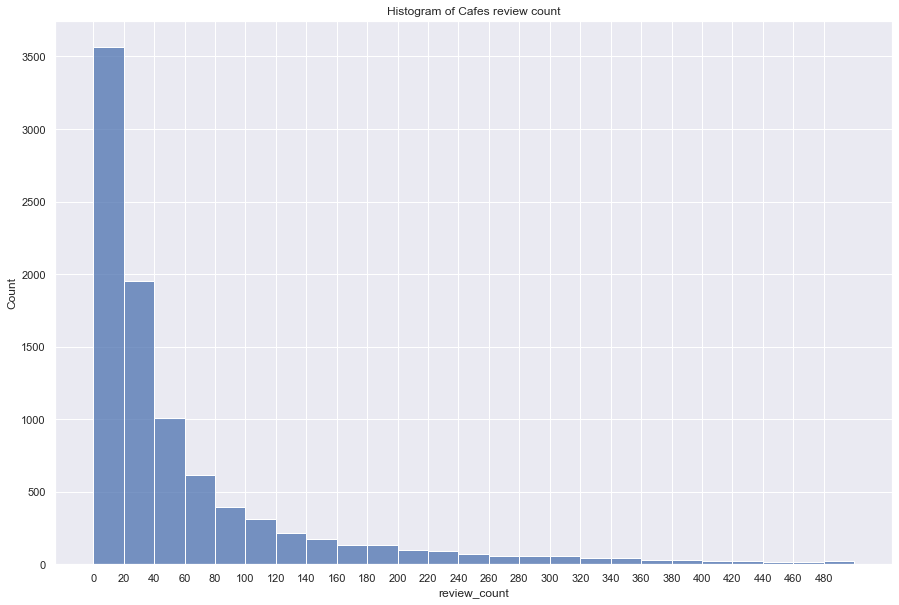

In [140]:
# check distribution of review count for the cafes category
sns.set_style('white')
sns.set(rc={'figure.figsize':(15,10)})
sns.histplot(cafes.review_count,
            binwidth=20,
            binrange=(0,500))
plt.xticks(np.arange(0,500,step=20))
plt.title('Histogram of Cafes review count');

In [147]:
# check unique states in the df
sorted(cafes['state'].unique())

['BC', 'CO', 'FL', 'GA', 'MA', 'MN', 'OH', 'OR', 'TX', 'WA']

In [146]:
# check unique cities in the df
sorted(cafes['city'].unique())

['ATLANTA',
 'AUSTIN',
 'Alafaya',
 'Allston',
 'Aloha',
 'Altamonte Springs',
 'Andover',
 'Apopka',
 'Arlington',
 'Atlanta',
 'Auburndale',
 'Austin',
 'Avon',
 'Avondale Estates',
 'BEAVERTON',
 'Bay Lake',
 'Beaverton',
 'Bedford',
 'Bee Cave',
 'Belle Isle',
 'Belmont',
 'Beverly',
 'Bexley',
 'Billerica',
 'Boston',
 'Boulder',
 'Bowen Island',
 'Braintree',
 'Brighton',
 'Brockton',
 'Brookhaven',
 'Brookline',
 'Buda',
 'Buena Ventura Lakes',
 'Burlington',
 'Burnaby',
 'Camas',
 'Cambridge',
 'Canal Winchester',
 'Canton',
 'Carlisle',
 'Casselberry',
 'Celebration',
 'Chamblee',
 'Champions Gate',
 'Championsgate',
 'Charlestown',
 'Chelsea',
 'Chestnut Hill',
 'Clackamas',
 'Clarkston',
 'Clermont',
 'Clintonville',
 'Cocoa',
 'Cohasset',
 'College Park',
 'Columbus',
 'Concord',
 'Coquitlam',
 'Damascus',
 'Danvers',
 'Davenport',
 'DeBary',
 'Debary',
 'Decatur',
 'Dedham',
 'Del Valle',
 'Delaware',
 'Delta',
 'Deltona',
 'Doctor Phillips',
 'Doraville',
 'Dorchester',
 

Given the great **coffee culture in Portland**, I have decided to build my unsupervised learning model prototype based on Portland cafes.

In [150]:
# filter cafes to a subset of cafes in NYC
cafes_portland = cafes[cafes['city']=='Portland']

In [151]:
cafes_portland.shape

(1218, 11)

In [158]:
cafes_portland.to_csv('/Users/valentinarizzati/Desktop/GitStuff/Projects/NLP-Yelp/data/yelp_cafes_portland.csv')

In [152]:
%%time
# keep only reviews that belong to cafes in portland 
reviews_cafes_portland = reviews_cafes[reviews_cafes.business_id.isin(cafes_portland.business_id.values)]

CPU times: user 650 ms, sys: 4.42 s, total: 5.07 s
Wall time: 9.89 s


In [153]:
reviews_cafes_portland.shape

(128770, 8)

In [159]:
# check duplicates
reviews_cafes_portland['review_id'].is_unique

True

In [160]:
# check nulls
reviews_cafes_portland.isnull().sum()

review_id      0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

In [157]:
len(reviews_cafes_portland)/len(reviews_cafes)

0.16783338916049417

----

Cafes in Portland represent ca. 17% of all cafes in the Yelp dataset.

----

In [161]:
reviews_cafes_portland.to_csv('/Users/valentinarizzati/Desktop/GitStuff/Projects/NLP-Yelp/data/yelp_reviews_cafes_portland.csv')

In [162]:
# Store df in pickle object to use in a different notebook for modeling
cafes_portland.to_pickle('cafes_portland.pickle')

In [163]:
# Store df in pickle object to use in a different notebook for modeling
reviews_cafes_portland.to_pickle('reviews_cafes_portland.pickle')